# SmartStock 🧠📈 – Time to build your portfolio!

* **Calculates** and **visualizes** popular *KPIs* like *RSI*, *Bollinger Bands*, and *MACD* for specific stocks,

* Looks at the *Price-to-Earnings (P/E) ratio* to help you understand how a stock is valued,

* Checks each stock’s *Beta* to show how risky or volatile it is compared to the overall market,

* Uses **GPT-4o** to summarize the data and give you clear, easy-to-understand investment insights,

* Helps you take steps toward an optimized portfolio by maximizing the **Sharpe Ratio** for better returns at a given level of risk,

* Allows you to add your own views with the **Black-Litterman model** to create a more customized and balanced portfolio,

# Setup

In [ ]:
!pip install langchain-openai yfinance PyPortfolioOpt

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from langchain_openai import ChatOpenAI
from IPython.display import display, Markdown
from pypfopt import expected_returns, risk_models, BlackLittermanModel, EfficientFrontier, black_litterman
from datetime import datetime, timedelta


In [ ]:
def initialize_llm(api_key):
  """
  Initialize the ChatOpenAI language model.

  Parameters:
    api_key (str): API key for the language model.

  Returns:
    ChatOpenAI: Initialized language model.
  """
  llm = ChatOpenAI(model="gpt-4o", temperature=0, api_key=api_key)
  return llm

In [ ]:
def calculate_date_range(years):
  end_date = datetime.today()
  start_date = end_date - timedelta(days=years * 365)
  return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

In [ ]:
def get_llm_response(llm, prompt):
  """
  Get response from an LLM using a given prompt.

  Parameters:
    llm (ChatOpenAI): Initialized language model.
    prompt (str): Prompt to send to the language model.

  Returns:
    str: Response from the language model.
  """
  response = llm.invoke(prompt)
  return display(Markdown(response.content))

In [ ]:
def plot_rsi(data, tickers):
    """
    Plot the Relative Strength Index (RSI) for a given asset.

    Parameters:
        data (DataFrame): Historical price data
        tickers (str): Stock ticker symbol.

    Returns:
        None
    """
    window = 14
    delta = data["Close"].diff()
    gain = (delta.where(delta > 0, 0).rolling(window=window).mean())
    loss = (-delta.where(delta < 0, 0).rolling(window=window).mean())
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, rsi, label="RSI", color="purple")
    plt.axhline(70, color='red', linestyle='--', label='Overbought (70)')
    plt.axhline(30, color='green', linestyle='--', label='Oversold (30)')
    plt.title(f"RSI of {tickers}")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.show()


In [ ]:
def plot_bollinger_bands(data, tickers):
    """
    Plot Bollinger Bands for a given asset.

    Parameters:
        data (DataFrame): The stock data.
        tickers (str): Stock ticker.

    Returns:
        None
    """
    window = 20

    # Ensure Close is a Series (not multilevel or DataFrame)
    close_prices = data["Close"]

    # Calculate Bollinger Bands
    middle_band = close_prices.rolling(window=window).mean()
    std = close_prices.rolling(window=window).std()
    upper_band = middle_band + 2 * std
    lower_band = middle_band - 2 * std

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, close_prices, label="Closing Price")
    plt.plot(data.index, middle_band, label="Middle Band", color="blue")
    plt.plot(data.index, upper_band, label="Upper Band", color="red")
    plt.plot(data.index, lower_band, label="Lower Band", color="green")
    plt.title(f"Bollinger Bands of {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

In [ ]:
def plot_pe_ratios(data, tickers, eps):
    """
    Plot the Price-to-Earnings (P/E) ratios over time for a given asset.

    Paremeters:
        data (DataFrame): Historical price data.
        ticker (str): List of stock tickers.
        eps (float): Earnings per share of the stock.

    Returns:
        None
    """
    try:
        # Validate EPS
        if eps is None or eps == 0:
            print(f"Warning: EPS for {ticker} is not available or zero. Skipping.")
            return

        # Calculate PE ratio
        pe_ratio = data["Close"] / eps

        # Plot PE ratio
        plt.figure(figsize=(10, 5))
        plt.plot(data.index, pe_ratio, label=f"{ticker} P/E Ratio")
        plt.title(f"P/E Ratio Over Time - {ticker}")
        plt.xlabel("Date")
        plt.ylabel("P/E Ratio")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

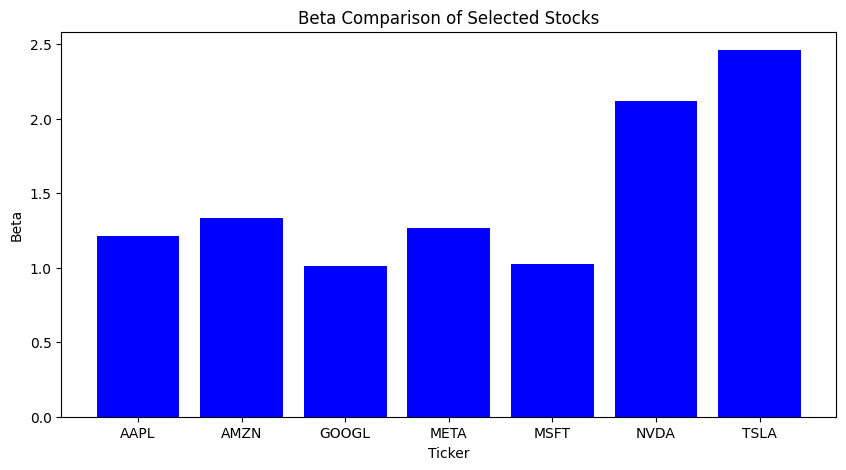

In [ ]:
def plot_beta_comparison(ticker, start_date, end_date):
  """
  Plot the beta values (volatility relative to market) of selected tickers.

  Parameters:
      betas (dict): Dictionary of ticker-beta pairs.

  Returns:
      None
  """
  betas = {}

  for ticker in tickers:
    stock = yf.Ticker(ticker)
    try:
      data = stock.history(start=start_date, end=end_date)
      beta = stock.info.get("beta")

      if beta is None:
        print(f"Warning: Beta value for {ticker} is not available.")
        continue

      betas[ticker] = beta
    except KeyError as e:
      print(f"Error fetching data for {ticker}: {e}")
    except Exception as e:
      print(f"Error processing {ticker}: {e}")

  # Plotting the bar chart
  plt.figure(figsize=(10, 5))
  plt.bar(betas.keys(), betas.values(), color="blue")
  plt.title("Beta Comparison of Selected Stocks")
  plt.xlabel('Ticker')
  plt.ylabel('Beta')
  plt.show()

plot_beta_comparison(ticker, start_date, end_date)

In [ ]:
def plot_macd(tickers, start_date, end_date):
    """
    Plot the Moving Average Convergence Divergence (MACD) for each ticker.

    Parameter:
        data (DataFrame): Historical price data.
        ticker (str): List of stock tickers.

    Returns:
        None
    """

    # Calculate MACD and signal line
    ema_12 = data["Close"].ewm(span=12, adjust=False).mean()
    ema_26 = data["Close"].ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    signal = macd.ewm(span=9, adjust=False).mean()

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, macd, label=f"{tickers} MACD", color="blue")
    plt.plot(data.index, signal, label=f"{tickers} Signal Line", color="orange")
    plt.title(f"MACD and Signal Line for {tickers}")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

In [ ]:
def calculate_kpis(tickers, start_date, end_date):
    """
    Calculate major KPIs (RSI, Bollinger Bands, PE Ratio, Beta, MACD) for a list of tickers.

    Parameters:
        tickers (list): List of stock tickers.
        start_date (str): Start date for data retrieval.
        end_date (str): End date for data retrieval.

    Returns:
        kpi_data (dict): A nested dictionary with KPI values per ticker.
    """
    kpi_data = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        data = stock.history(start=start_date, end=end_date)
        kpi_data[ticker] = {}

        # RSI
        window = 14
        delta = data['Close'].diff()
        gain = delta.where(delta > 0, 0).rolling(window=window).mean()
        loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        kpi_data[ticker]['RSI'] = rsi

        # Bollinger Bands
        window = 20
        mid = data['Close'].rolling(window=window).mean()
        std = data['Close'].rolling(window=window).std()
        kpi_data[ticker]['Bollinger Bands'] = {
            'Middle Band': mid,
            'Upper Band': mid + 2 * std,
            'Lower Band': mid - 2 * std
        }

        # P/E Ratio
        try:
            eps = stock.info.get("trailingEps")
            if eps and eps != 0:
                pe_ratio = data["Close"] / eps
                kpi_data[ticker]['P/E Ratio'] = pe_ratio
            else:
                kpi_data[ticker]['P/E Ratio'] = None
        except Exception as e:
            kpi_data[ticker]['P/E Ratio'] = None
            print(f"Error processing {ticker}: P/E Ratio not available")

        # Beta
        try:
            beta = stock.info.get("beta")
            kpi_data[ticker]['Beta'] = beta
        except Exception as e:
            kpi_data[ticker]['Beta'] = None
            print(f"Error processing {ticker}: {e}")

        # MACD
        ema_12 = data["Close"].ewm(span=12, adjust=False).mean()
        ema_26 = data["Close"].ewm(span=26, adjust=False).mean()
        macd = ema_12 - ema_26
        signal = macd.ewm(span=9, adjust=False).mean()
        kpi_data[ticker]['MACD'] = {
            'MACD': macd,
            'Signal Line': signal
        }

    return kpi_data

# API KEY
(Replace api_key with your OpenAI API Key – https://platform.openai.com)

In [ ]:
# API Key for accessing OpenAI services
api_key = "YOUR_API_KEY"

# Inputs

In [ ]:
llm = initialize_llm(api_key)

In [ ]:
# Define number of years for analysis
years = 2

In [ ]:
# List of assets to analyze
assets = [
    'AAPL',      # Apple Inc.
    'AMZN',      # Amazon.com, Inc.
    'BTC-USD',   # Bitcoin (in USD)
    'GOOGL',     # Alphabet Inc. (Google)
    'META',      # Meta Platforms, Inc.
    'MSFT',      # Microsoft Corporation
    'NVDA',      # NVIDIA Corporation
    'SPY',       # SPDR S&P 500 ETF (market proxy)
    'TSLA'       # Tesla Inc.
]

In [ ]:
# Define query for the ticker
query = f"""
Fetch me the tickers from the following assets: {assets}
Your output must be sorted alphabetically by the ticker and it should be formatted like this:
tickers = ['AAPL','AMZN','BTC-USD','GOOGL','META','MSFT','NVDA','SPY','TSLA']
"""

In [ ]:
get_llm_response(llm=llm, prompt=query)

Certainly! Here is the list of tickers sorted alphabetically:

```python
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']
```

In [ ]:
# Convert asssets names to their ticker symbols
tickers = ['AAPL', 'AMZN', 'BTC-USD', 'GOOGL', 'META', 'MSFT', 'NVDA', 'SPY', 'TSLA']

In [ ]:
# Calculate the start & end dates
start_date, end_date = calculate_date_range(years)

# Fetch historical stock data using yfinance
data = yf.download(tickers, start=start_date, end=end_date)

# Display first few rows of fetched data
data.head()

/tmp/ipython-input-58-4285067758.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  9 of 9 completed


Price            Close                                                    \
Ticker            AAPL        AMZN       BTC-USD       GOOGL        META   
Date                                                                       
2023-07-13  188.651199  134.300003  31476.048828  123.797546  311.699982   
2023-07-14  188.799683  134.679993  30334.068359  124.672287  307.184753   
2023-07-15         NaN         NaN  30295.806641         NaN         NaN   
2023-07-16         NaN         NaN  30249.132812         NaN         NaN   
2023-07-17  192.066971  133.559998  30145.888672  123.906891  308.925201   

Price                                                            High  ...  \
Ticker            MSFT       NVDA         SPY        TSLA        AAPL  ...   
Date                                                                   ...   
2023-07-13  337.413330  45.948719  437.904449  277.899994  189.294765  ...   
2023-07-14  339.953857  45.441036  437.631683  281.380005  189.284816  ...   
2023-07-15         NaN        NaN         NaN         NaN         NaN  ...   
2023-07-16         NaN        NaN         NaN         NaN         NaN  ...   
2023-07-17  340.436340  46.432426  439.151245  290.380005  192.393701  ...   

Price             Open      Volume                                       \
Ticker            TSLA        AAPL        AMZN      BTC-USD       GOOGL   
Date                                                                      
2023-07-13  274.589996  41342300.0  61170900.0  23686079548  44297900.0   
2023-07-14  277.010010  41573900.0  54388100.0  20917902660  33266800.0   
2023-07-15         NaN         NaN         NaN   8011667756         NaN   
2023-07-16         NaN         NaN         NaN   8516564470         NaN   
2023-07-17  286.630005  50520200.0  48450200.0  13240156074  25716200.0   

Price                                                                     
Ticker            META        MSFT         NVDA         SPY         TSLA  
Date                                                                      
2023-07-13  30281000.0  20567200.0  478204000.0  72425200.0  112681500.0  
2023-07-14  22576000.0  28302200.0  772075000.0  69761800.0  119771100.0  
2023-07-15         NaN         NaN          NaN         NaN          NaN  
2023-07-16         NaN         NaN          NaN         NaN          NaN  
2023-07-17  25323100.0  20363900.0  510488000.0  52680200.0  131569600.0  

[5 rows x 45 columns]

# Outputs

### RSI

**What it is:**
Relative Stength Index (RSI) is a momentum oscillator that measures the speed and magnitude of recent price changes. It helps identify overbought and oversold conditions in a stock or asset.

**How to interpret:**

* Above 70 → The asset is considered overbought (potential reversal or pullback).

* Below 30 → The asset is considered oversold (potential bounce or recovery).

* Between 30-70 → Neutral range; trend may continue.

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


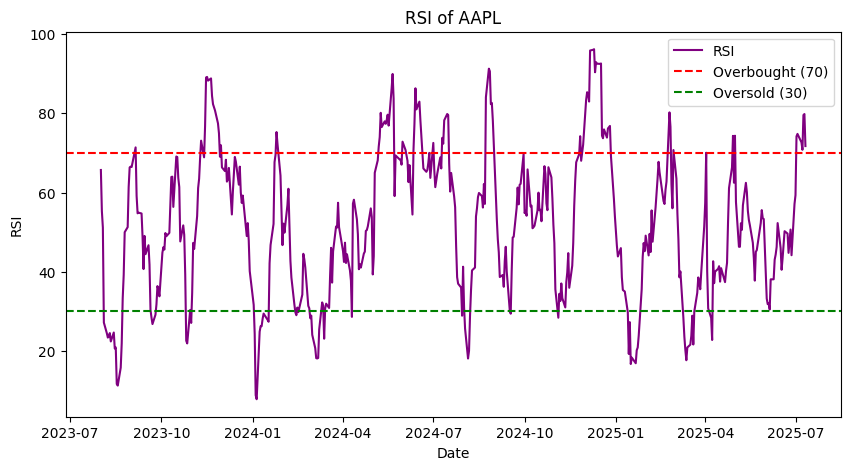

[*********************100%***********************]  1 of 1 completed


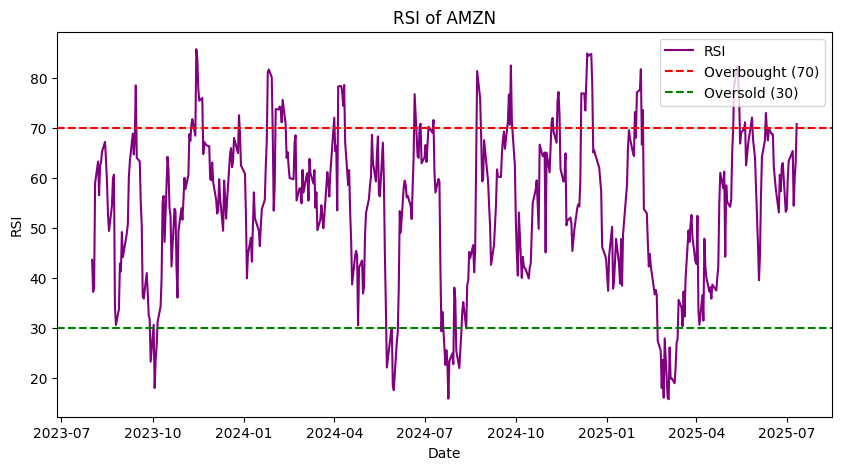

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


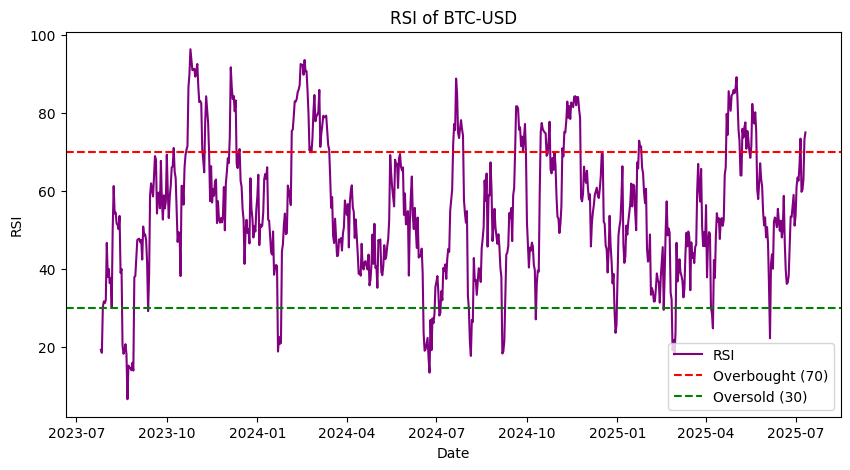

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


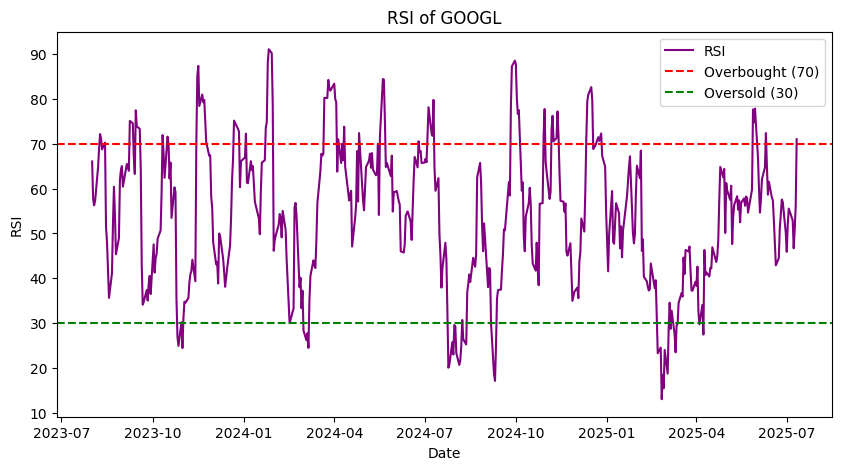

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


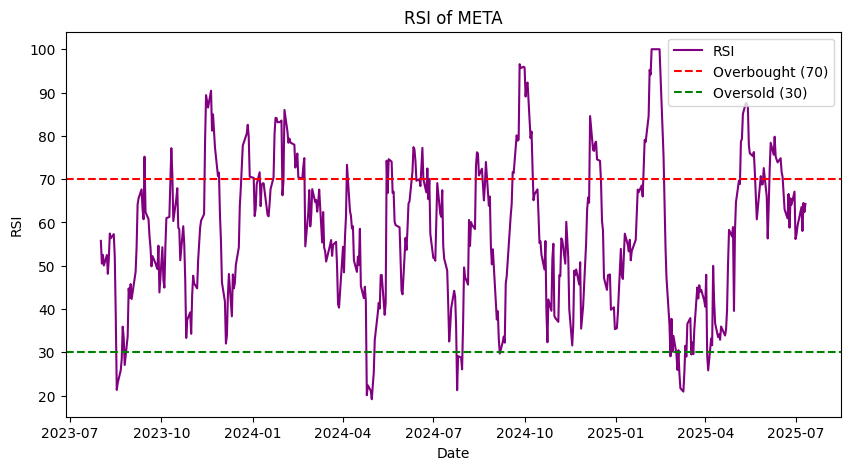

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


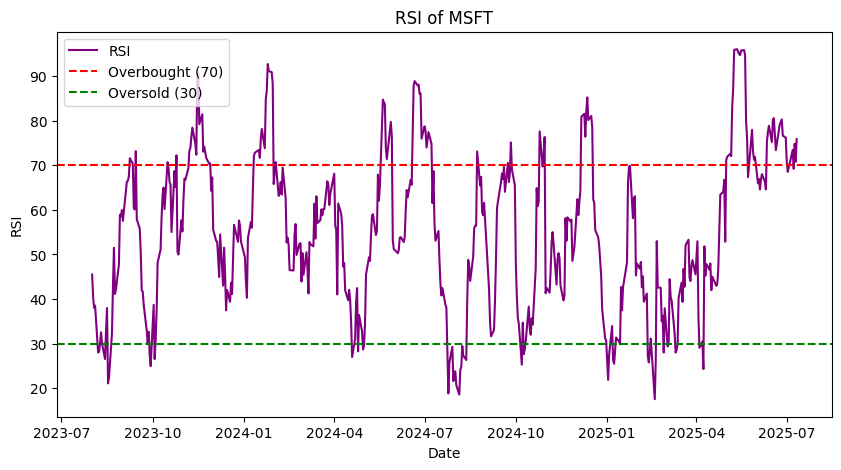

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


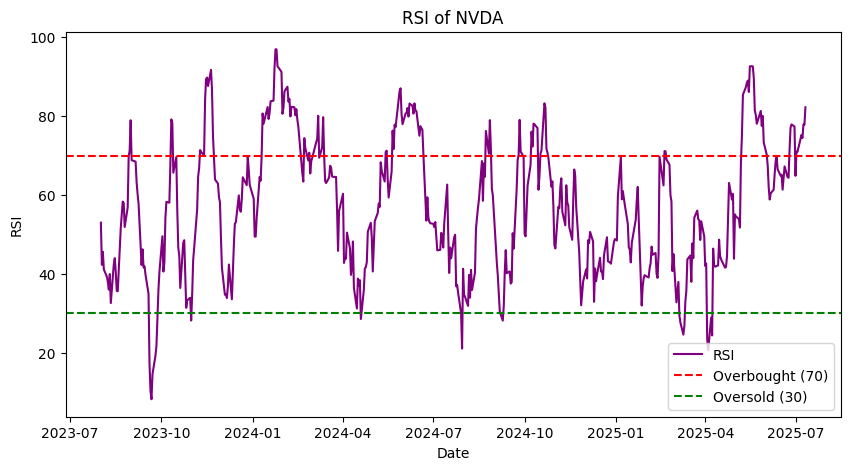

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


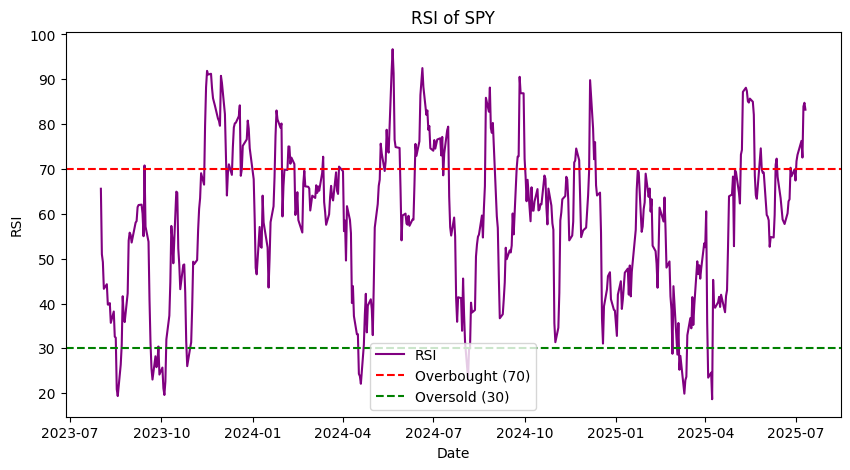

/tmp/ipython-input-59-1378247077.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


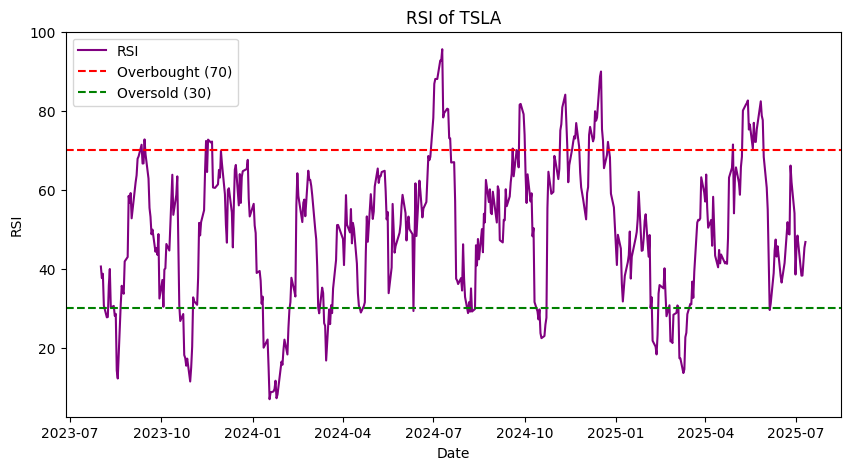

In [ ]:
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_rsi(data_ticker, ticker)

### Bollinger Bands

**What it is:**
Bollinger Bands consist of a moving average (middle band) and two standard deviation bands above and below it (upper/lower bands). It’s a volatility indicator.

---

**How to interpret:**
* Price touches upper band → Overbought / potential resistance

* Price touches lower band → Oversold / potential support

* Bands widen → Increased volatility

* Bands contract → Low volatility or a potential breakout coming

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


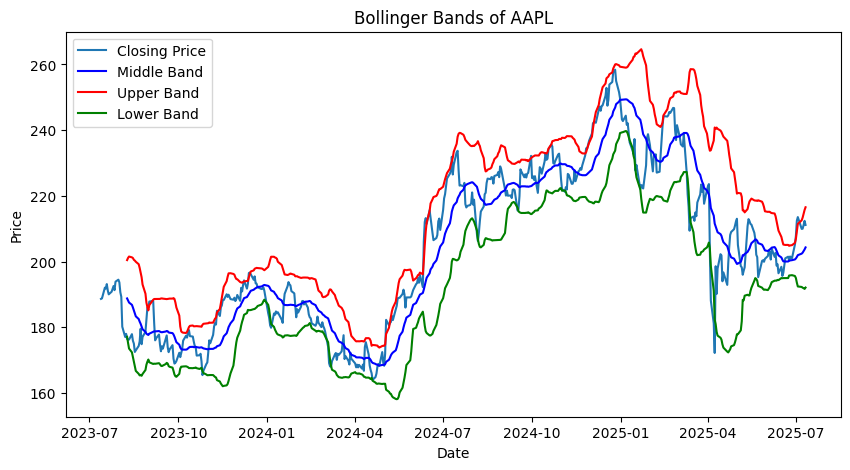

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


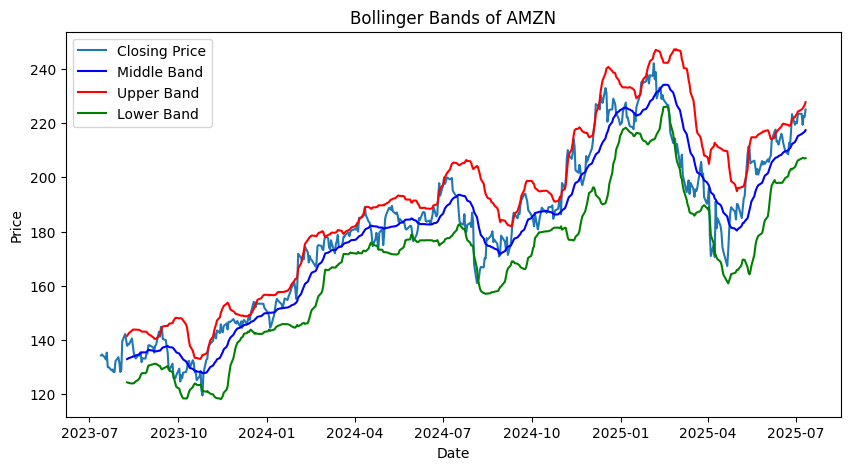

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


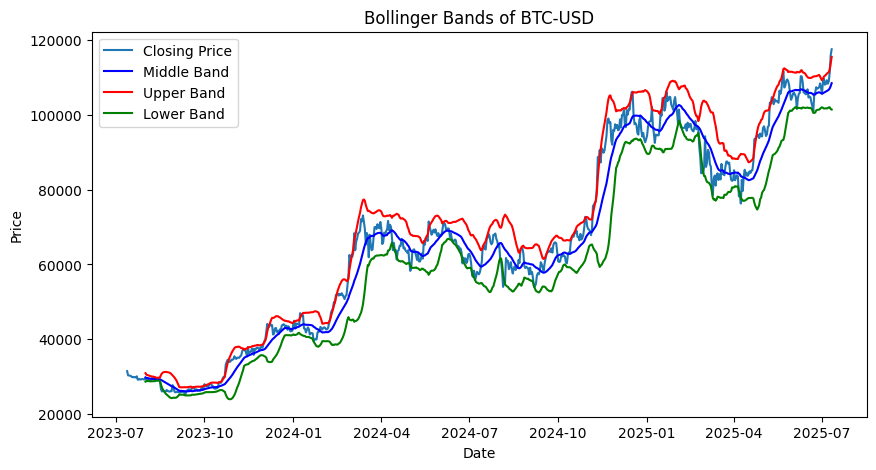

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


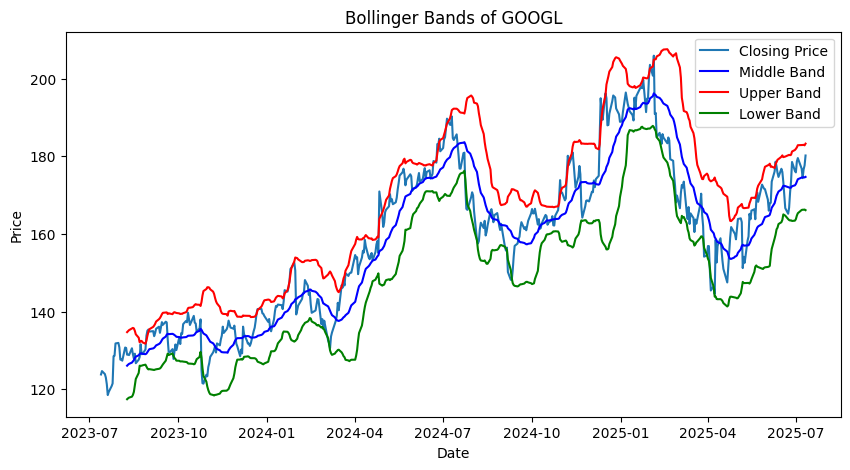

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


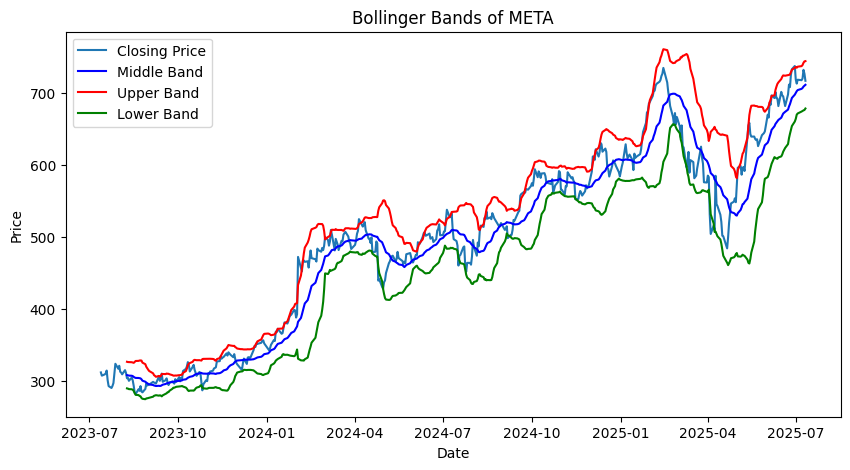

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


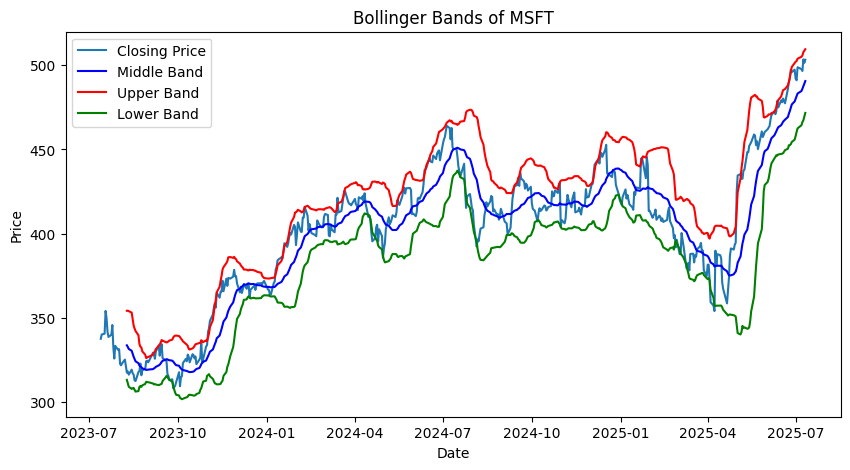

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


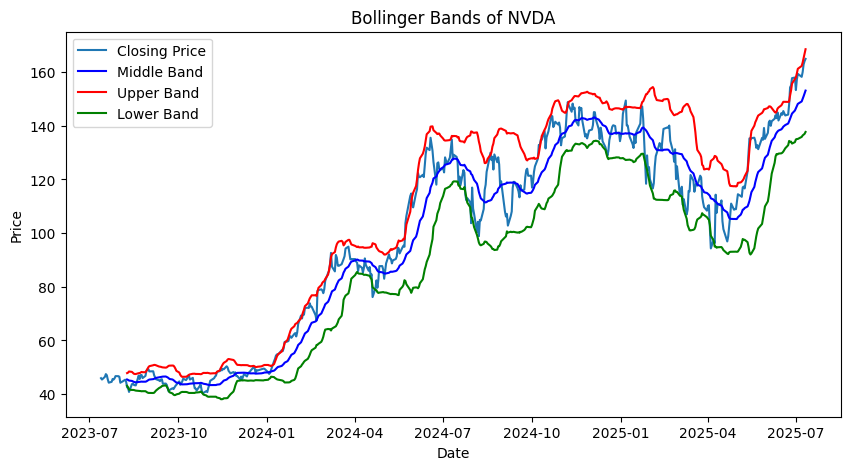

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


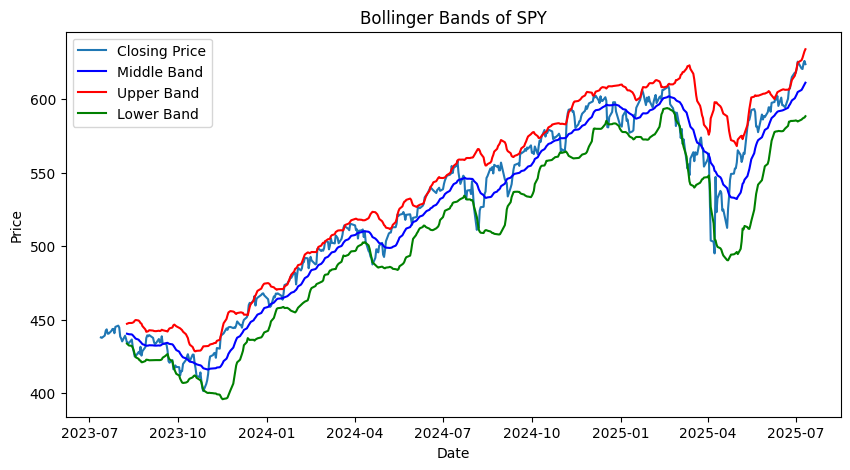

/tmp/ipython-input-65-2167791100.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


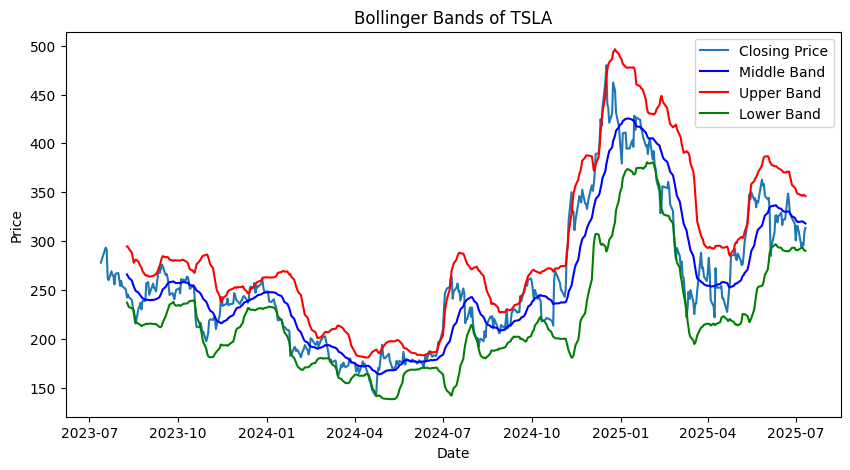

In [ ]:
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_bollinger_bands(data_ticker, ticker)

### Price-to-Earnings Ratio (P/E)

**What it is:**
P/E ratio compares a company’s stock price to its earnings per share (EPS). It’s a valuation metric used to determine how "expensive" a stock is relative to earnings.


---


**How to interpret:**
* **High P/E (e.g., 30+)** → Market expects strong future growth (may also mean overvaluation).

* **Low P/E (e.g., <15)** → Potential undervaluation or underperformance.

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


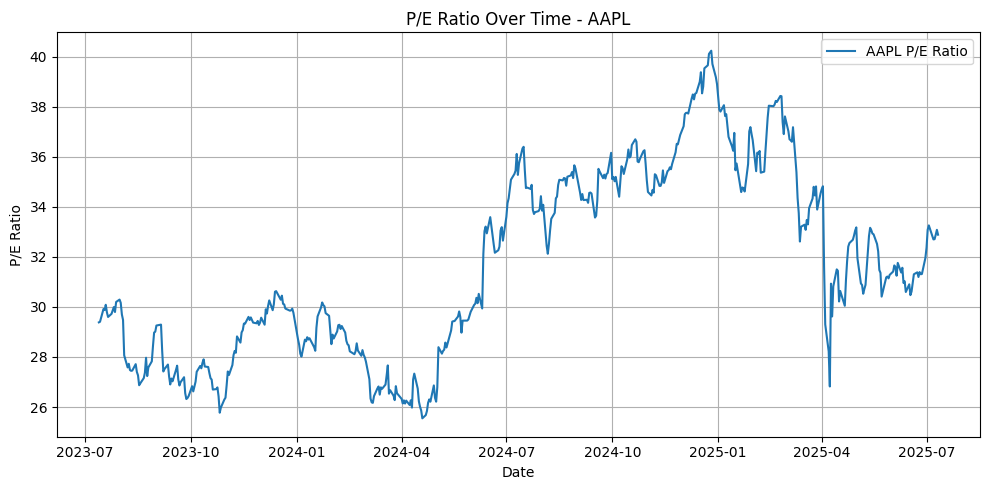

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


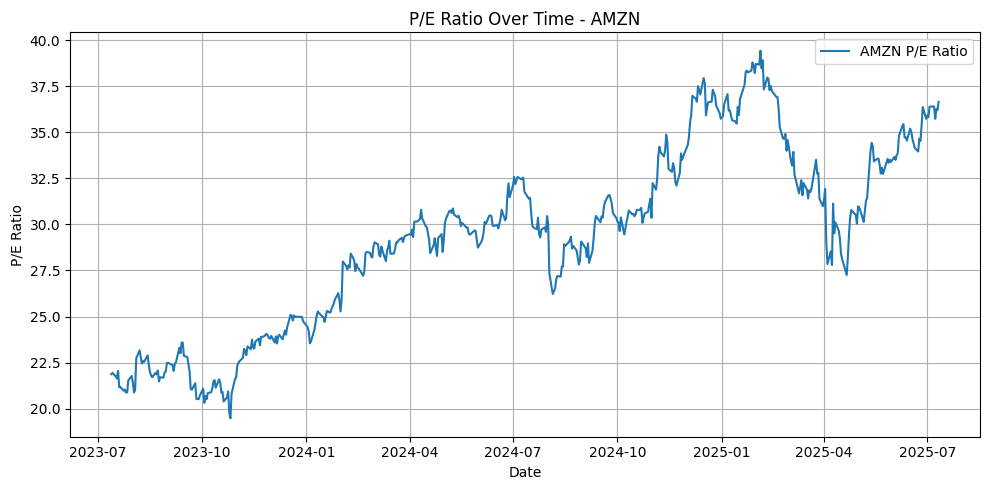

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


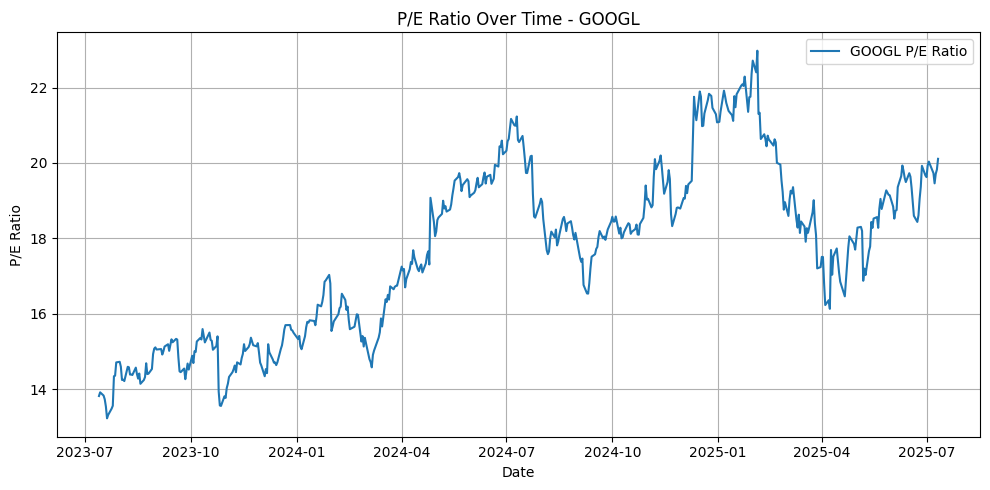

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


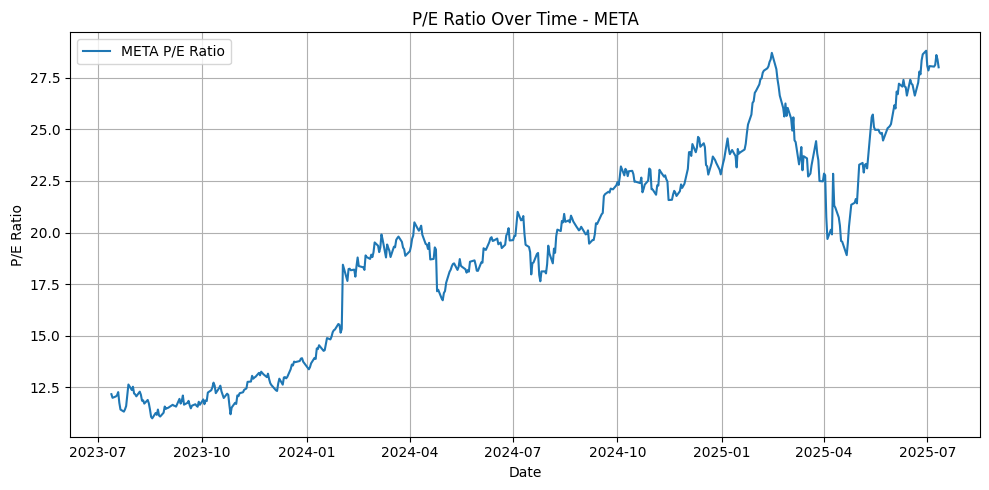

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


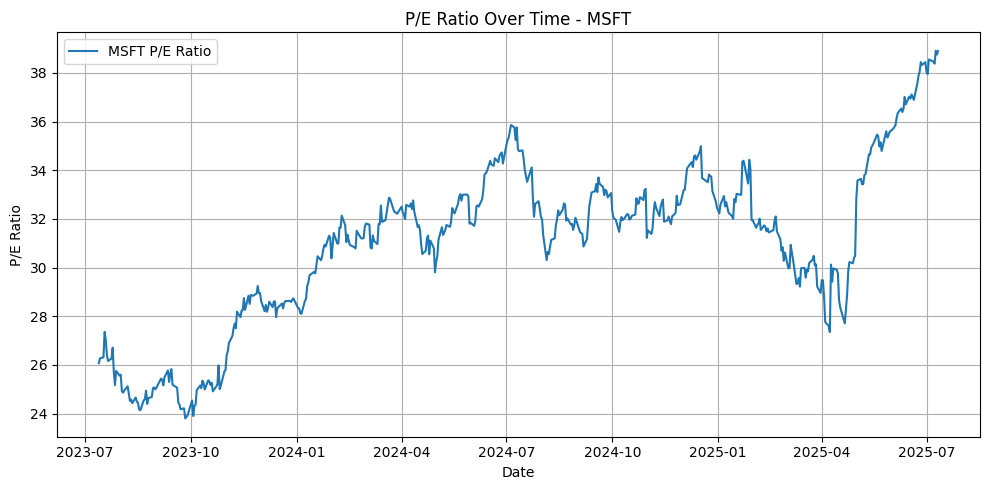

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


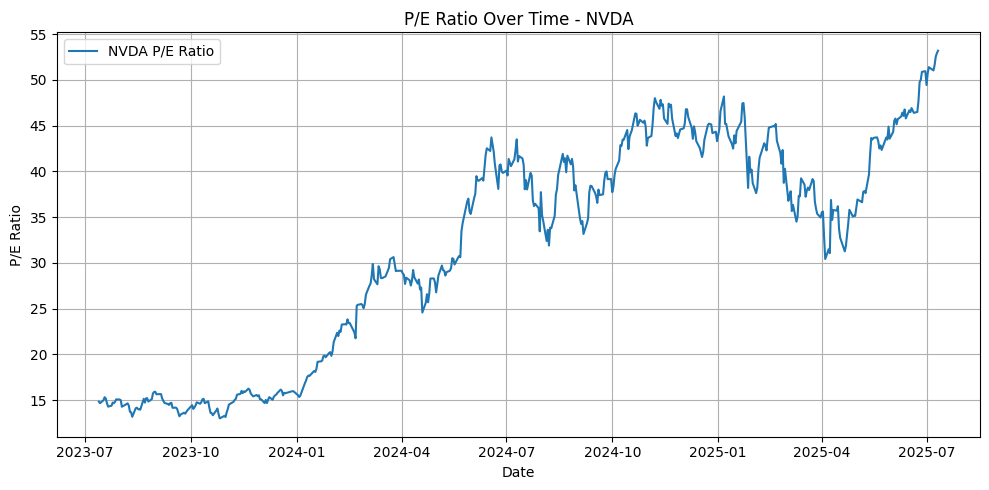

/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


/tmp/ipython-input-68-2701637909.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


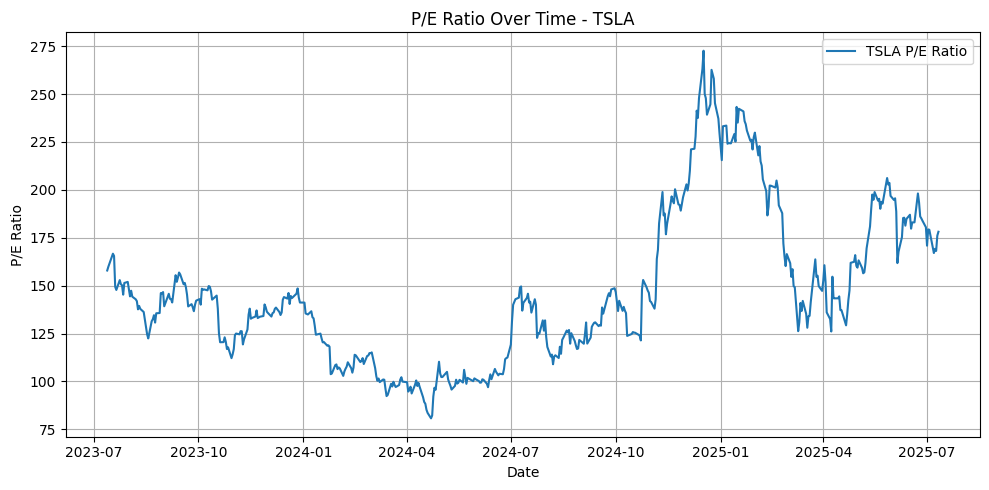

In [ ]:
for ticker in tickers:
    stock = yf.Ticker(ticker)
    eps = stock.info.get("trailingEps")
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_pe_ratios(data_ticker, ticker, eps)

### Beta

**What it is:**
Beta measures an asset’s volatility relative to the market (typically the S&P 500). It shows systematic risk — how much the asset tends to move when the market moves.

---

**How to interpret:**

* **Beta = 1** → Moves in line with the market

* **Beta > 1** → More volatile than the market (e.g., Beta = 1.5 means 50% more volatile)

* **Beta < 1** → Less volatile or defensive (e.g., utilities)

* **Negative Beta** → Moves inversely to market (rare)

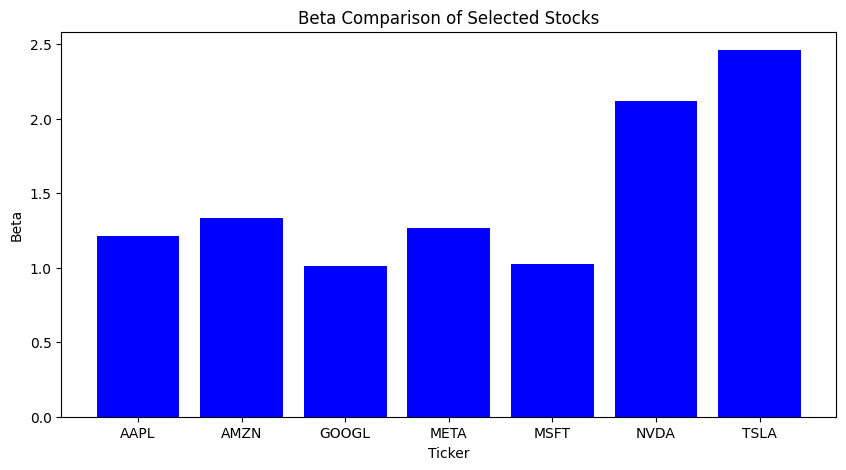

In [ ]:
plot_beta_comparison(tickers, start_date, end_date)

### Moving Average Convergence Divergence

**What it is:**
MACD is a trend-following momentum indicator. It shows the difference between two exponential moving averages (typically 12- and 26-day), along with a signal line (9-day EMA of MACD).

---

**How to interpret:**
* **MACD > Signal Line** → Bullish signal

* **MACD < Signal Line** → Bearish signal

* **MACD crosses above** 0 → Uptrend starting

* **MACD crosses below 0** → Downtrend starting

[*********************100%***********************]  1 of 1 completed


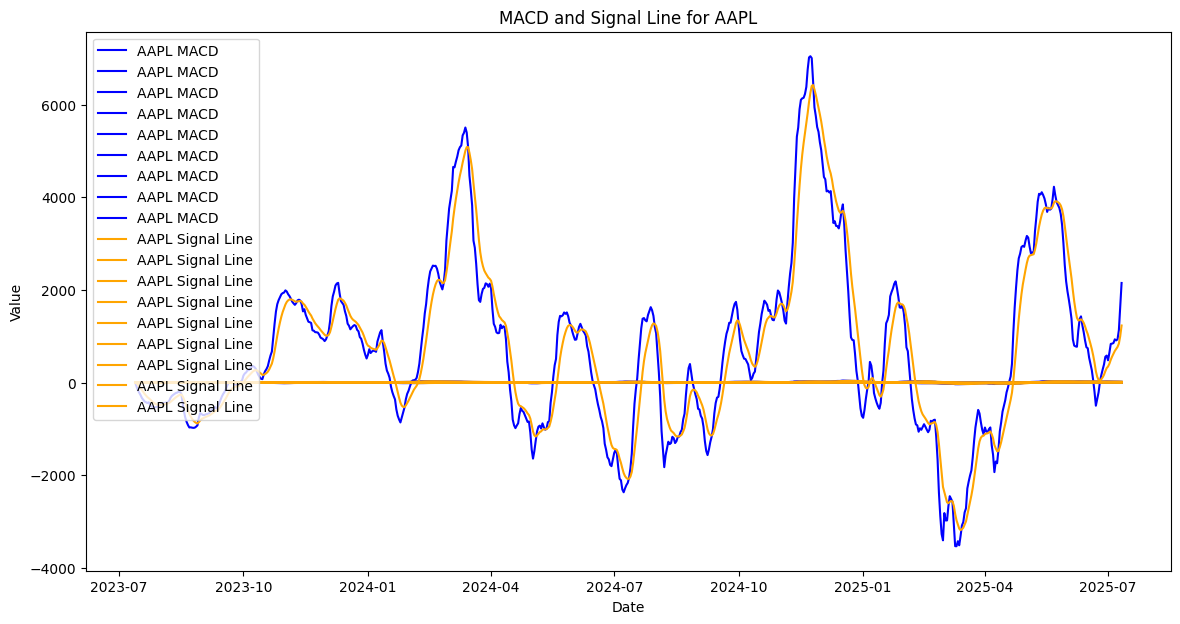

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


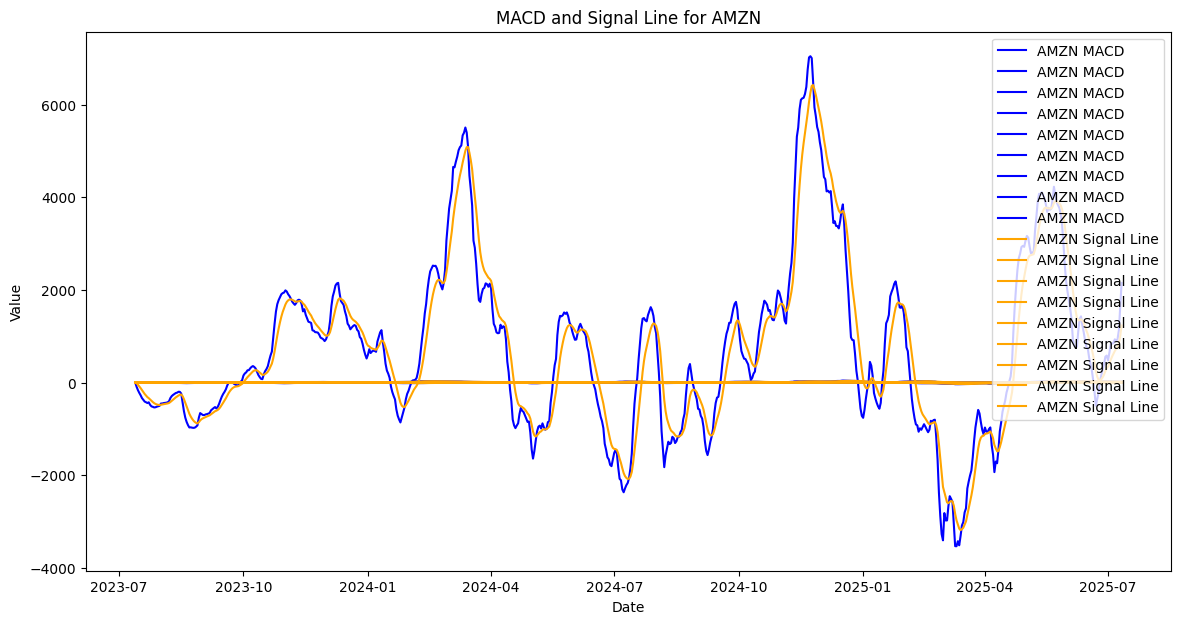

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


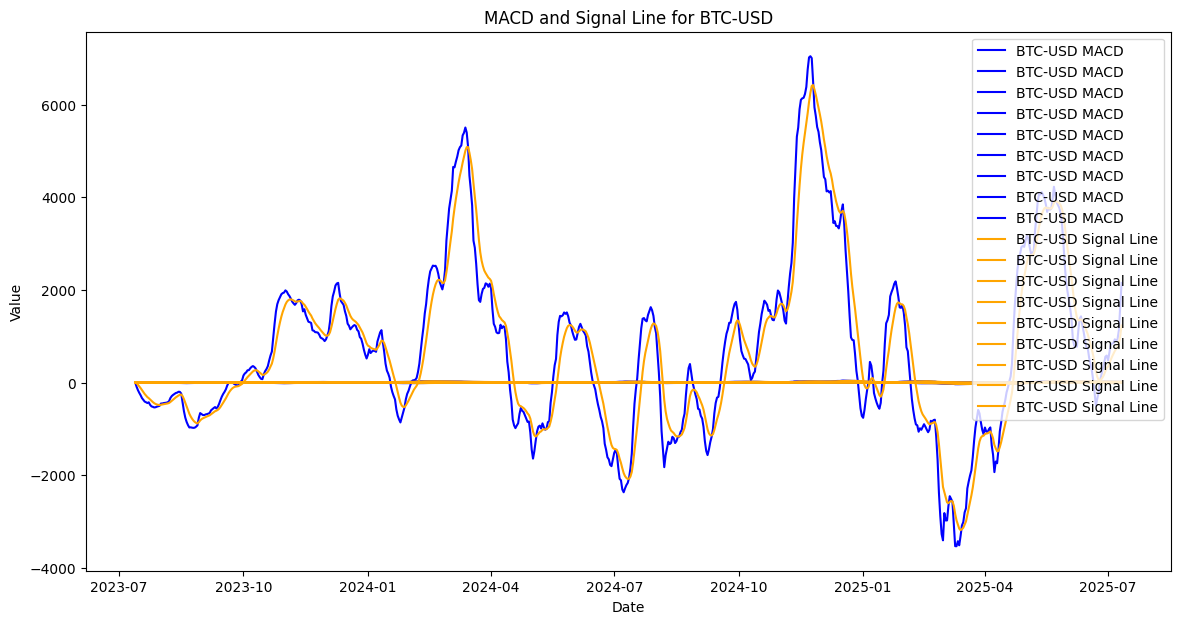

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


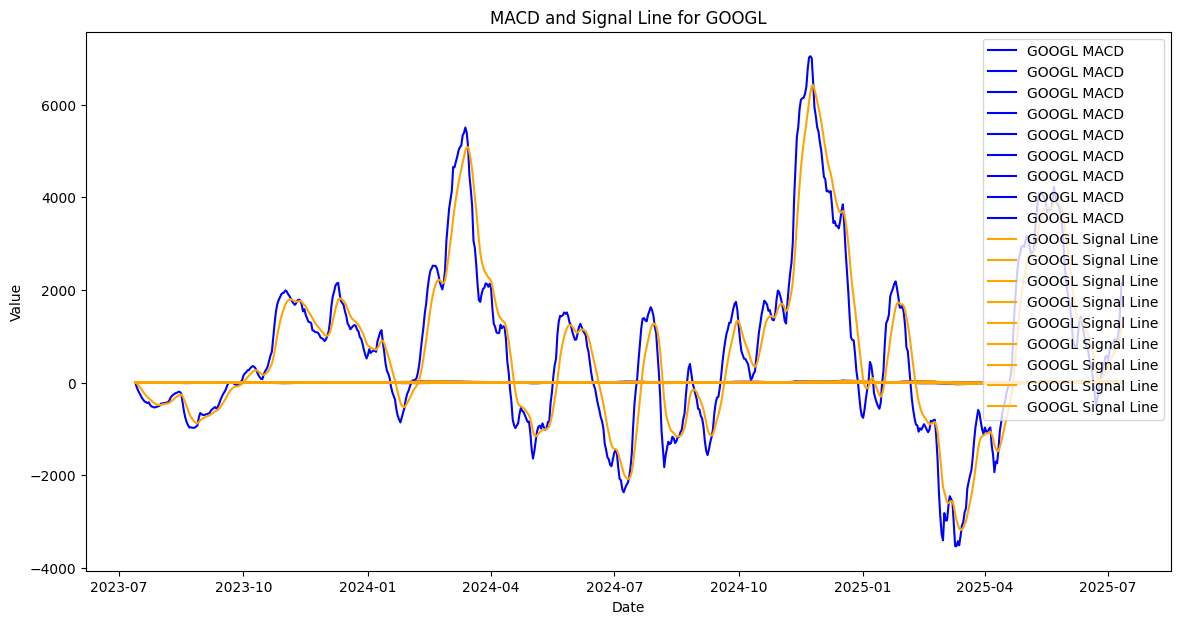

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


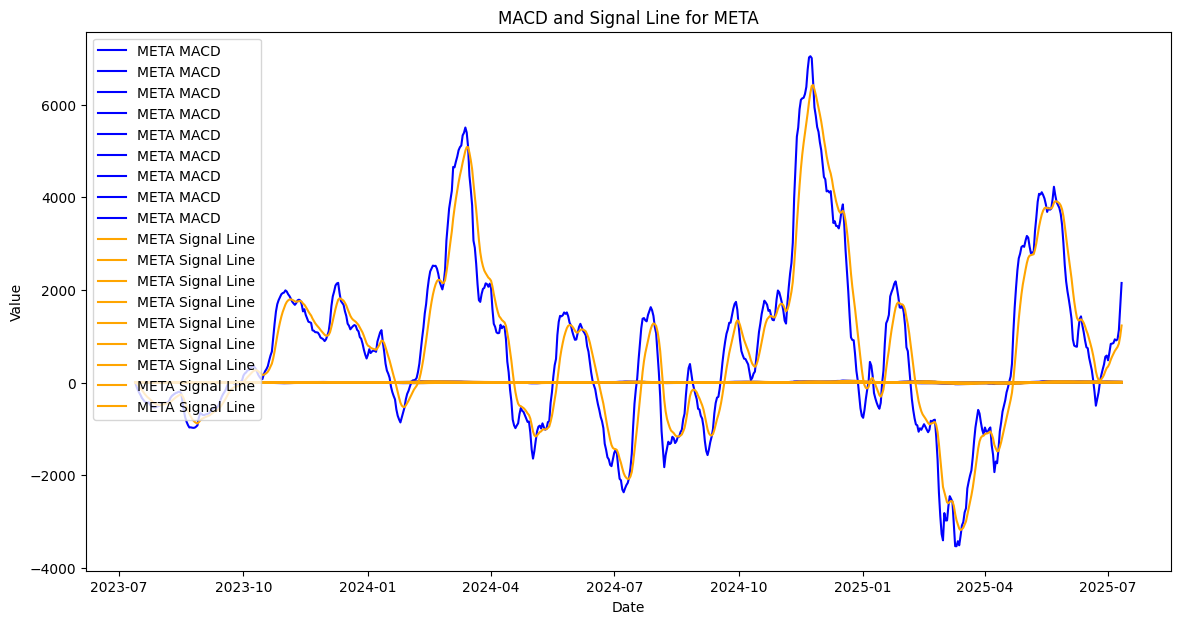

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


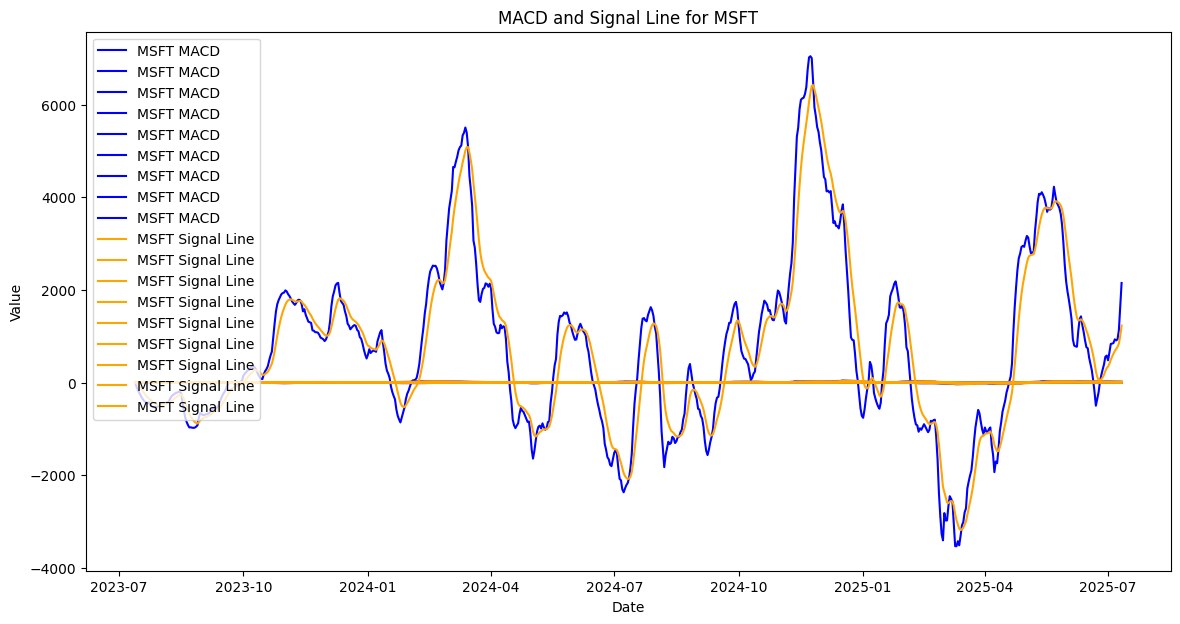

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


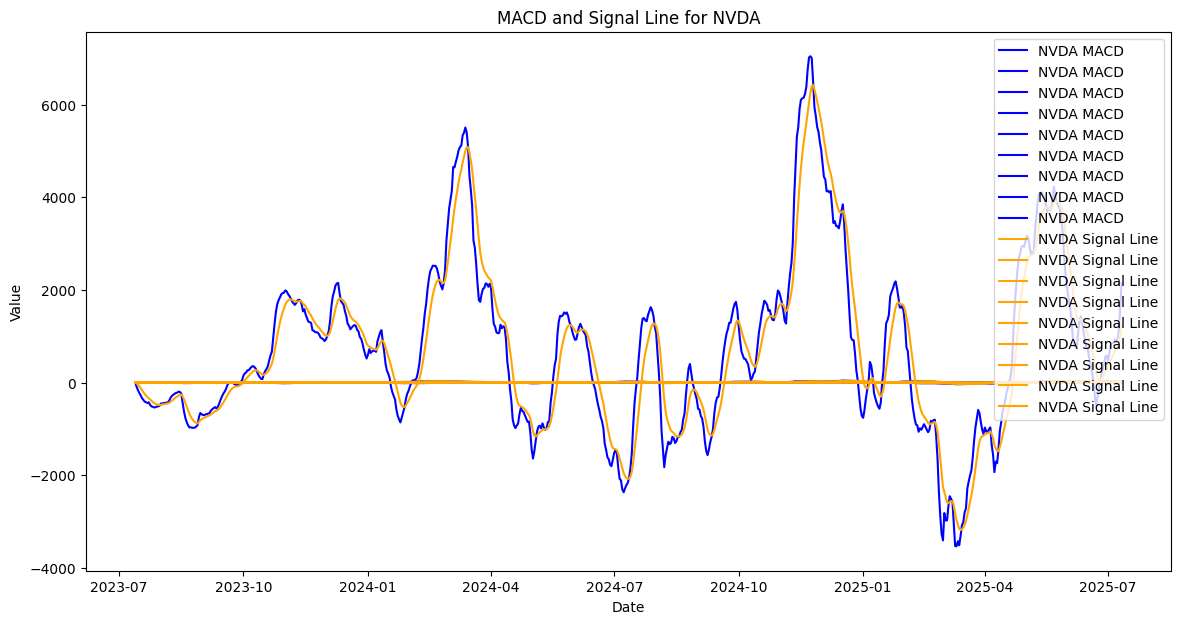

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


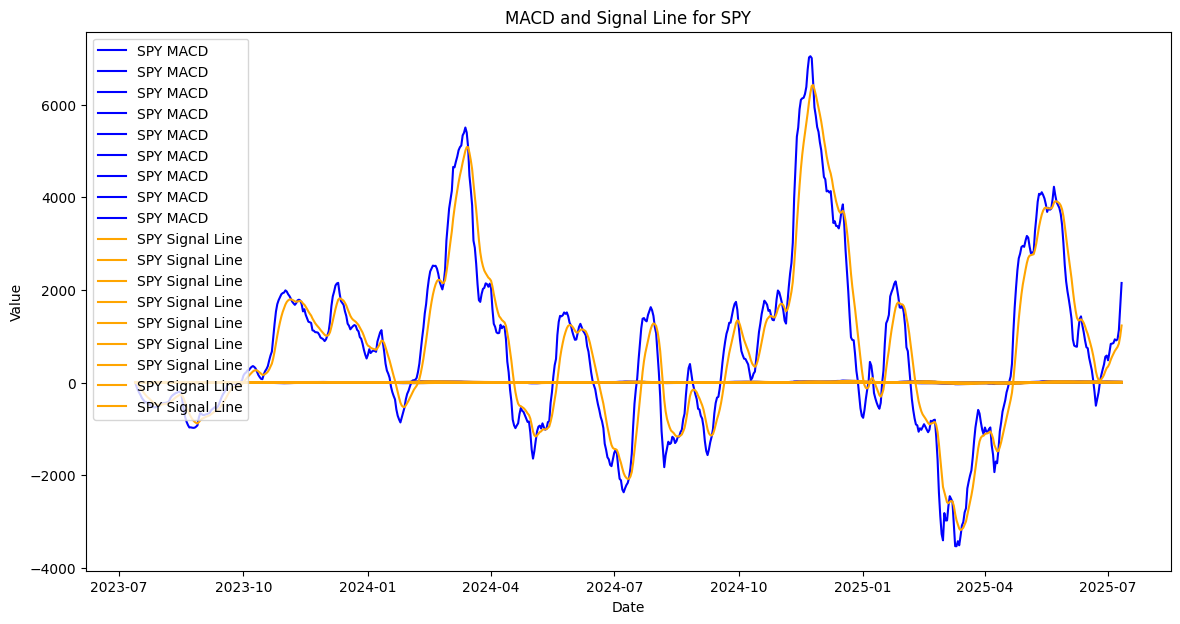

/tmp/ipython-input-70-2928217922.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_ticker = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


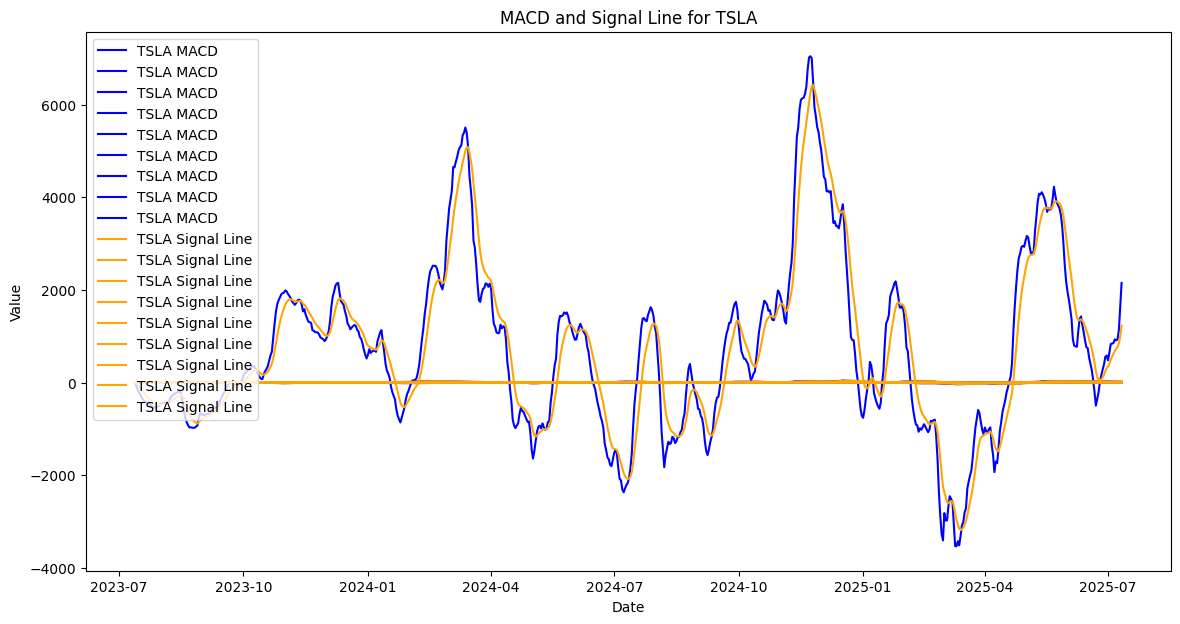

In [ ]:
for ticker in tickers:
    data_ticker = yf.download(ticker, start=start_date, end=end_date)
    plot_macd(ticker, start_date, end_date)

### KPIs

In [ ]:
# Calculate KPIs for defined tickers & data range
kpi_data = calculate_kpis(tickers, start_date, end_date)

prompt = f"""Read this data {kpi_data} and provide an executive summary with recommendations."""
get_llm_response(llm=llm, prompt=prompt)

### Executive Summary

The data provided includes technical indicators and financial metrics for several major stocks and assets, including AAPL, AMZN, BTC-USD, GOOGL, META, MSFT, NVDA, SPY, and TSLA. The indicators analyzed include the Relative Strength Index (RSI), Bollinger Bands, Price-to-Earnings (P/E) Ratio, Beta, and Moving Average Convergence Divergence (MACD). These indicators provide insights into the momentum, volatility, valuation, and market risk of each asset.

### Key Observations

1. **AAPL (Apple Inc.)**
   - **RSI**: Currently above 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band, suggesting potential overvaluation.
   - **P/E Ratio**: Relatively high at around 32, indicating a premium valuation.
   - **MACD**: Positive and above the signal line, indicating bullish momentum.
   - **Recommendation**: Consider taking profits or holding, as the stock may be overbought.

2. **AMZN (Amazon.com Inc.)**
   - **RSI**: Around 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **P/E Ratio**: High at around 36, suggesting a premium valuation.
   - **MACD**: Positive but close to the signal line, indicating weakening momentum.
   - **Recommendation**: Monitor closely for potential pullback; consider holding.

3. **BTC-USD (Bitcoin)**
   - **RSI**: Above 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **MACD**: Strong positive divergence from the signal line, indicating strong bullish momentum.
   - **Recommendation**: Consider taking profits or holding, as the asset may be overbought.

4. **GOOGL (Alphabet Inc.)**
   - **RSI**: Approaching 70, indicating potential overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **P/E Ratio**: Moderate at around 20, suggesting reasonable valuation.
   - **MACD**: Positive and above the signal line, indicating bullish momentum.
   - **Recommendation**: Hold, as the stock shows bullish momentum with reasonable valuation.

5. **META (Meta Platforms Inc.)**
   - **RSI**: Around 64, indicating neutral to slightly overbought conditions.
   - **Bollinger Bands**: Price is within the bands, indicating normal volatility.
   - **P/E Ratio**: Moderate at around 28, suggesting reasonable valuation.
   - **MACD**: Positive but close to the signal line, indicating weakening momentum.
   - **Recommendation**: Hold, as the stock is fairly valued with stable momentum.

6. **MSFT (Microsoft Corp.)**
   - **RSI**: Above 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **P/E Ratio**: High at around 39, indicating a premium valuation.
   - **MACD**: Positive and above the signal line, indicating bullish momentum.
   - **Recommendation**: Consider taking profits or holding, as the stock may be overbought.

7. **NVDA (NVIDIA Corp.)**
   - **RSI**: Above 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **P/E Ratio**: Very high at around 53, indicating a premium valuation.
   - **MACD**: Positive and above the signal line, indicating strong bullish momentum.
   - **Recommendation**: Consider taking profits, as the stock may be overbought and overvalued.

8. **SPY (S&P 500 ETF)**
   - **RSI**: Above 70, indicating overbought conditions.
   - **Bollinger Bands**: Price is near the upper band.
   - **MACD**: Positive and above the signal line, indicating bullish momentum.
   - **Recommendation**: Consider taking profits or holding, as the ETF may be overbought.

9. **TSLA (Tesla Inc.)**
   - **RSI**: Below 50, indicating neutral to slightly oversold conditions.
   - **Bollinger Bands**: Price is within the bands, indicating normal volatility.
   - **P/E Ratio**: Extremely high at around 178, indicating a very premium valuation.
   - **MACD**: Negative and below the signal line, indicating bearish momentum.
   - **Recommendation**: Consider buying on dips or holding, as the stock may be oversold.

### General Recommendations

- **Overbought Assets**: For assets with RSI above 70 and prices near the upper Bollinger Band, consider taking profits or holding, as they may be due for a pullback.
- **Fairly Valued Assets**: For assets with moderate P/E ratios and stable momentum, consider holding.
- **Oversold Assets**: For assets with RSI below 50 and bearish momentum, consider buying on dips.

Investors should consider their risk tolerance and investment horizon before making any decisions. It is also advisable to keep an eye on macroeconomic factors that could impact these assets.

### MPT

In [ ]:
def portfolio_performance(weights, mean_returns, cov_matrix):
    """
    Calculate portfolio expected return and standard deviation.

    Parameters:
      weights (array): Asset weights in the portfolio.
      mean_returns (Series): Expected (mean) returns for each asset.
      cov_matrix (DataFrame): Covariance matrix of asset returns.

    Returns:
      tuple: (expected annual return, annual standard deviation)
    """
    returns = np.sum(mean_returns * weights) * 252  # Annualize returns
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)  # Annualize std
    return returns, std

def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Compute negative Sharpe ratio for optimization (we minimize it).

    Parameters:
      weights (array): Portfolio weights.
      mean_returns (Series): Expected returns.
      cov_matrix (DataFrame): Covariance matrix.
      risk_free_rate (float): Annual risk-free rate.

    Returns:
      float: Negative Sharpe ratio.
    """
    p_returns, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    sharpe_ratio = (p_returns - risk_free_rate) / p_std
    return -sharpe_ratio

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    """
    Optimize portfolio weights to maximize the Sharpe ratio.

    Parameters:
      mean_returns (Series): Mean returns for each asset.
      cov_matrix (DataFrame): Covariance matrix of asset returns.
      risk_free_rate (float): Annual risk-free rate.

    Returns:
      OptimizeResult: Result of the optimization process.
    """
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Weights must sum to 1

    initial_guess = [1. / num_assets] * num_assets

    result = minimize(negative_sharpe_ratio,
                      initial_guess,
                      args=args,
                      method='SLSQP',
                      bounds=bounds,
                      constraints=constraints)

    return result

# Fetch adjusted close prices for the tickers
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Calculate daily returns
returns = data.pct_change().dropna()

# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
risk_free_rate = 0.04

# Optimize portfolio for max. Sharpe ratio
optimal_portfolio = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
optimal_weights = optimal_portfolio.x

# Store the optimal weights in a dict
weights_dict = {tickers[i]: round(optimal_weights[i], 2) for i in range(len(tickers))}
print(weights_dict)


[*********************100%***********************]  9 of 9 completed
/tmp/ipython-input-74-1681446226.py:66: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = data.pct_change().dropna()


{'AAPL': np.float64(0.0), 'AMZN': np.float64(0.0), 'BTC-USD': np.float64(0.45), 'GOOGL': np.float64(0.0), 'META': np.float64(0.23), 'MSFT': np.float64(0.0), 'NVDA': np.float64(0.32), 'SPY': np.float64(0.0), 'TSLA': np.float64(0.0)}


**Modern Portfolio Theory (MPT)** aims to optimize the portfolio's return for a given level of risk.

The **Sharpe ratio** is used to measure the performance of the portfolio compared to a risk-free asset, after adjusting for its risk. The portfolio with the highest Sharpe ratio is considered optimal.

### Black-Litterman Model

In [ ]:
risk_free_rate = 0.001

# Fetch historical adjusted close prices only
df = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Estimate expected returns and covariance matrix
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)

# Define market capitalizations
mcap = {}
for ticker in tickers:
    try:
        mcap[ticker] = yf.Ticker(ticker).info.get("marketCap", 0)
    except:
        mcap[ticker] = 0
mcap["SPY"] = 49_000_000_000_000  # Estimated market cap for SPY

# Define views: MSFT expected to outperform GOOGL by 5%
Q = np.array([0.05])
P = np.zeros((1, len(tickers)))
P[0, tickers.index("MSFT")] = 1
P[0, tickers.index("GOOGL")] = -1

# Get market-implied prior returns
market_prices = df['SPY']  # ✅ This now works because df is ['Adj Close']
delta = black_litterman.market_implied_risk_aversion(market_prices)
pi = black_litterman.market_implied_prior_returns(mcap, delta, S, risk_free_rate)

# Build the Black-Litterman model
bl = BlackLittermanModel(
    S,
    pi=pi,
    Q=Q,
    P=P,
    market_weights=pi,
    risk_free_rate=risk_free_rate
)

# Get adjusted returns and covariance
bl_returns = bl.bl_returns()
bl_cov = bl.bl_cov()

# Optimize the portfolio using max Sharpe ratio
ef = EfficientFrontier(bl_returns, bl_cov)
weights = ef.max_sharpe(risk_free_rate=risk_free_rate)
cleaned_weights = ef.clean_weights()

# Display results
print("🧠 Optimal Portfolio Weights (Black-Litterman):")
print(cleaned_weights)

# Portfolio performance
ef.portfolio_performance(verbose=True)

[*********************100%***********************]  9 of 9 completed
/usr/local/lib/python3.11/dist-packages/pypfopt/expected_returns.py:32: UserWarning: Some returns are NaN. Please check your price data.
  warnings.warn(


🧠 Optimal Portfolio Weights (Black-Litterman):
OrderedDict([('AAPL', 0.04126), ('AMZN', 0.02401), ('BTC-USD', 0.03244), ('GOOGL', 0.0), ('META', 0.0237), ('MSFT', 0.11448), ('NVDA', 0.05725), ('SPY', 0.69342), ('TSLA', 0.01344)])
Expected annual return: 26.5%
Annual volatility: 19.8%
Sharpe Ratio: 1.33


/usr/local/lib/python3.11/dist-packages/pypfopt/black_litterman.py:80: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rets = market_prices.pct_change().dropna()
/usr/local/lib/python3.11/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(np.float64(0.2647947382955695),
 np.float64(0.1979670062374927),
 np.float64(1.3325187025311986))